In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

titanic = pd.read_csv("Your path here /train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
titanic.groupby(['Survived']).size()/len(titanic)
#Survived only 0.38% 

Survived
0    0.616162
1    0.383838
dtype: float64

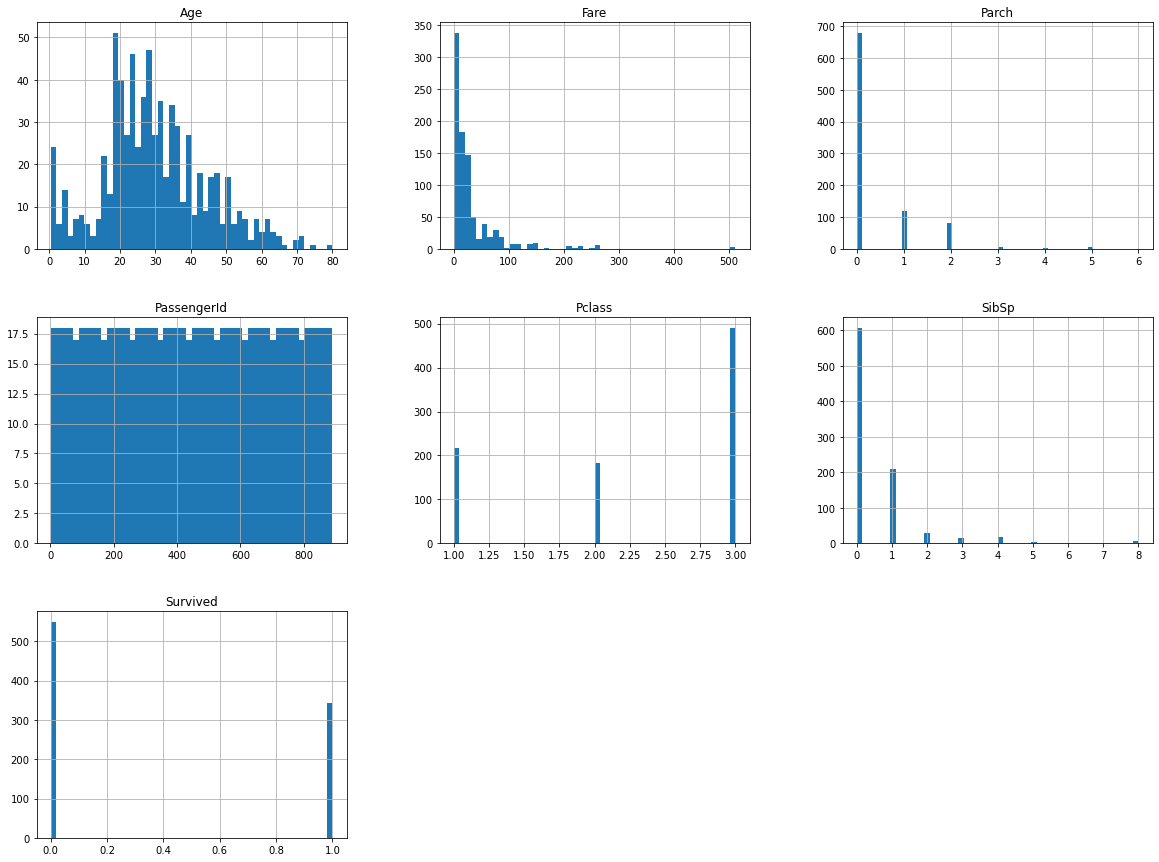

In [14]:
import matplotlib.pyplot as plt
titanic.hist(bins=50,figsize=(20,15))
plt.show()

#Observations
#Age: most people between 20-40 years
#Fare: most people paid between 0-50 
#Pclass: most people are pclass 3

In [126]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#Sampling train and test set with stratified shuffling on Pclass, 80% train 20% test
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(titanic, titanic["Pclass"]):
    strat_train = titanic.loc[train_index]
    strat_test = titanic.loc[test_index]
    
Y_train = strat_train["Survived"].copy()
X_train = strat_train.drop(columns=list(["Survived"]))

In [134]:
#Preparing the dataframe
import numpy as np
from collections import Counter

class AttributeTransformer():  
        
    def add_features(self, X, fun_list=[]):
        for fun in fun_list:
            X = fun(X)
        
        return X
    
    def drop_outliers(self, X, n, columns):
        outlier_ix = []
    
        for col in columns:
            Q1 = np.percentile(X[col], 25)
            Q3 = np.percentile(X[col],75)
            # Interquartile range (IQR)
            IQR = Q3 - Q1        
            # outlier step
            outlier_step = 1.5 * IQR

            # Index's list of outliers for each col
            outlier_list_col = X[(X[col] < Q1 - outlier_step) | (X[col] > Q3 + outlier_step )].index
            outlier_ix.extend(outlier_list_col)

        # select observations containing more than 2 outliers
        outlier_ix = Counter(outlier_ix)        
        multiple_outliers = list( k for k, v in outlier_ix.items() if v > n )        

        X = X.drop(multiple_outliers, axis = 0).reset_index(drop=True)
        
        return X

def fun_woman_ch(X):
    X['Woman_ch'] = np.where(  (X['Sex'] == 'female') | (X['Age'] <= 15) , 1, 0)
    return X
        
def fun_age(X):
    X['Age'].fillna(X['Age'].median(), inplace=True)
    X['Age_group'] = np.where(  (X['Age'] <= 15) , 1, 0)
    X['Age_group'] = np.where(  (X['Age'] > 15) & (X['Age'] < 60) , 2, X['Age_group'])
    X['Age_group'] = np.where(  (X['Age'] >= 60 ) , 3, X['Age_group'])
    return X

def fun_relatives(X):
    X['Relatives'] = X['SibSp'] + X['Parch']
    return X

def fun_relatives_group(X):
    X['Relatives_group'] = np.where( ( (X['SibSp'] + X['Parch'] == 0)) | (X['SibSp'] + X['Parch'] > 3), 1, 0)
    return X

def fun_title(X):
    X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                         'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    X['Title'] = X['Title'].replace('Mlle', 'Miss')
    X['Title'] = X['Title'].replace('Ms', 'Miss')
    X['Title'] = X['Title'].replace('Mme', 'Mrs')
    X['Title_group'] = X["Title"].map({"Master":0, "Miss":0, "Ms" : 0 ,
                                                         "Mme":0, "Mlle":0, "Mrs":1, "Mr":0, "Other":0})
    return X



attribute_transformer = AttributeTransformer()
fun_list = [fun_woman_ch, fun_age, fun_relatives, fun_relatives_group, fun_title, fun_embarked]
strat_train_comb = attribute_transformer.drop_outliers(strat_train, 2, ["Age","SibSp","Parch","Fare"])
strat_train_comb = attribute_transformer.add_features(strat_train, fun_list)

strat_train_comb

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Woman_ch,Age_group,Relatives,Relatives_group,Title,Title_group
820,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S,1,2,2,0,Mrs,1
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S,0,2,0,1,Mr,0
821,822,1,3,"Lulic, Mr. Nikola",male,27.0,0,0,315098,8.6625,NaN,S,0,2,0,1,Mr,0
403,404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S,0,2,1,0,Mr,0
343,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,NaN,S,0,2,0,1,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,0,2,6,1,Mr,0
789,790,0,1,"Guggenheim, Mr. Benjamin",male,46.0,0,0,PC 17593,79.2000,B82 B84,C,0,2,0,1,Mr,0
51,52,0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.8000,NaN,S,0,2,0,1,Mr,0
625,626,0,1,"Sutton, Mr. Frederick",male,61.0,0,0,36963,32.3208,D50,S,0,3,0,1,Mr,0


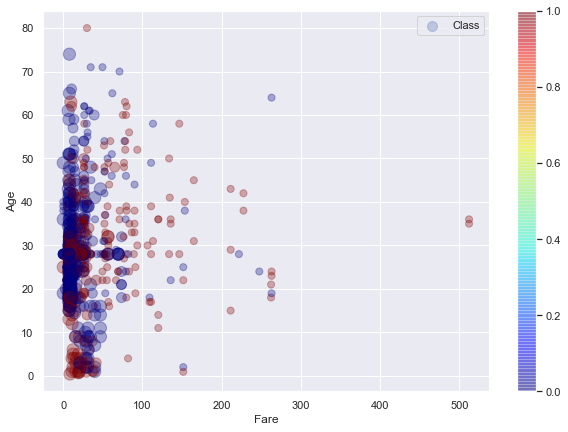

In [135]:
strat_train_comb.plot(kind="scatter", x="Fare", y="Age", alpha=0.3, figsize=(10,7), c=strat_train_comb.Survived, 
               s=strat_train.Pclass*50, label="Class",
               cmap=plt.get_cmap("jet"),colorbar=True, sharex=False) 
#People who didn't survived likely to be on 1st or 2nd class
#Also the fare is closely related to the Class
#Age actually doesn't matter too much except when age < 15

In [136]:
corr_matrix = strat_train_comb.corr()
corr_matrix["Survived"].sort_values(ascending=False)
#More fare = more probability of survive
#Less pclass = more probability of survive

Survived           1.000000
Woman_ch           0.569375
Title_group        0.346018
Fare               0.251609
Parch              0.059978
PassengerId        0.010203
Relatives         -0.010197
Age               -0.060040
SibSp             -0.060153
Age_group         -0.123156
Relatives_group   -0.271901
Pclass            -0.334031
Name: Survived, dtype: float64

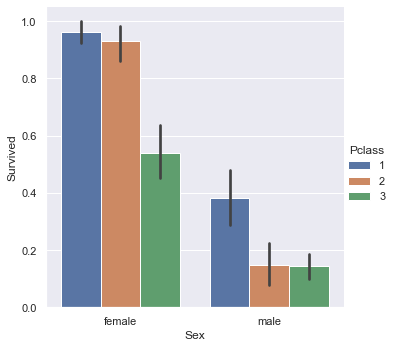

In [137]:
#Women first
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=strat_train_comb)

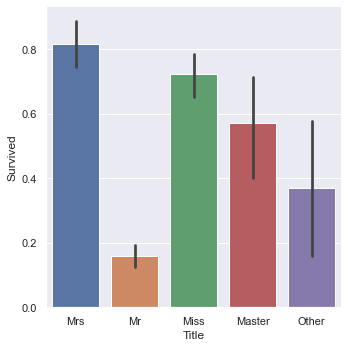

In [138]:
#Miss and Mrs high survival rate = women
sns.catplot(x="Title", y="Survived", kind="bar", data=strat_train_comb)

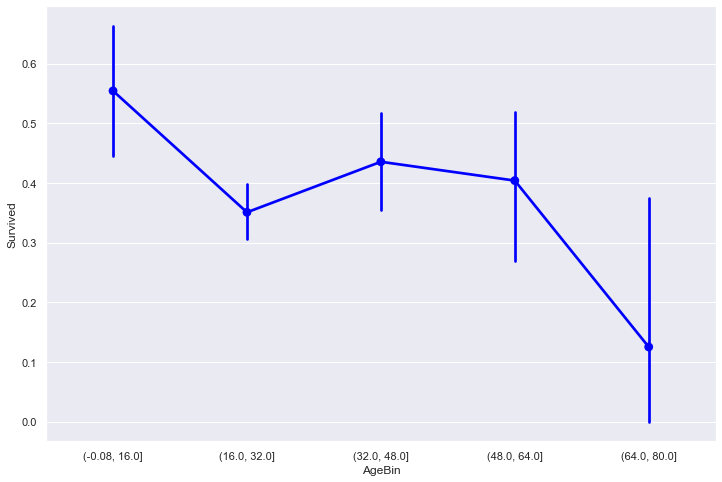

In [139]:
strat_train_plot = strat_train_comb.copy()
strat_train_plot['AgeBin'] = pd.cut(strat_train_transf['Age'].astype(int), 5)

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=strat_train_plot, color='blue', ax=ax)
#3 groups :
# Age [0,16] = high survival rate
# Age [16,64] = medium survival rate
# Age [64,] = low survival rate
#Children first

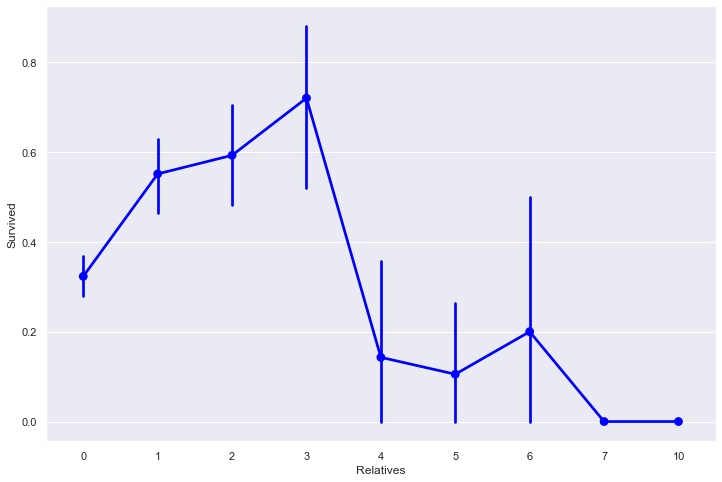

In [140]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.pointplot(x = 'Relatives', y = 'Survived',  data=strat_train_plot, color='blue', ax=ax)

# groups based on number of relatives
# relatives = 0 | relatives >=4  --> people who traveled alone or with too many relatives has low survival rate
# relatives >= 1 & relatives <= 3  --> people who traveled with some relatives  has high survival rate

In [142]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

class MyNumPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, strategy):
        self.strategy = strategy
        self.num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy=self.strategy)),
            ('std_scaler', StandardScaler())
        ])
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.num_pipeline.fit_transform(X)
        
class MyCatPipeline(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OrdinalEncoder()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.encoder.fit_transform(X)
    
class MyFullPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, my_num_pipeline, my_cat_pipeline, num_attribs, cat_attribs):
        self.my_num_pipeline = my_num_pipeline
        self.my_cat_pipeline = my_cat_pipeline
        self.num_attribs = num_attribs
        self.cat_attribs = cat_attribs
        self.my_full_pipeline = ColumnTransformer([
            ("num", my_num_pipeline, num_attribs),
            ("cat", my_cat_pipeline, cat_attribs),
        ])
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.my_full_pipeline.fit_transform(X)
    
titanic_num_attribs = ["Relatives", "Fare"]
titanic_cat_attribs = ["Sex","Pclass", "Relatives_group", "Age_group", "Woman_ch", "Title_group"]
my_full_pipeline = MyFullPipeline(my_num_pipeline=MyNumPipeline(strategy="median"),
                                  my_cat_pipeline=MyCatPipeline(),
                                  num_attribs=titanic_num_attribs,
                                  cat_attribs=titanic_cat_attribs)

X_train = my_full_pipeline.fit_transform(strat_train_comb)
X_train[0]

array([0.68625759, 1.259243  , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        ])

In [144]:
rnd_forest_clf = RandomForestClassifier(random_state=42)
rnd_forest_clf.fit(X_train, Y_train)

y_pred = rnd_forest_clf.predict(X_train)
n_correct = sum(y_pred == Y_train)
print(n_correct/len(y_pred)) 

0.9367977528089888


In [145]:
cross_val_score = cross_val_score(rnd_forest_clf, X_train, Y_train, cv=5)
cross_val_score

array([0.82517483, 0.84615385, 0.88732394, 0.78169014, 0.8028169 ])

In [146]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score


classifiers = [RandomForestClassifier(random_state=42), 
               SVC(random_state=42),
               AdaBoostClassifier(random_state=42),
               GradientBoostingClassifier(random_state=42),
               GaussianNB(), 
               LogisticRegression(random_state=42),
               KNeighborsClassifier(),
               DecisionTreeClassifier(random_state=42)
               ]

matrix_score =np.empty((8, 4))
for ix, clf in enumerate(classifiers):
    y_pred = cross_val_predict(clf, X_train, Y_train, cv=5)
    n_correct = sum(y_pred == Y_train)
    matrix_score[ix,0] = n_correct/len(y_pred)
    matrix_score[ix,1] = precision_score(Y_train, y_pred)
    matrix_score[ix,2] = recall_score(Y_train, y_pred)
    matrix_score[ix,3] = f1_score(Y_train, y_pred)
    



classifiers = ["Random Forest", "Support Vector Classifier", "Ada Boost", 
        "Gradient Boost","Naive Bayes","LogisiticRegression", "K Neighbors", "Decision Tree"]
score_labels =["Predict/Actual value", "precision", "recall", "f1"]

scores = pd.DataFrame(data=matrix_score, index=classifiers, columns=score_labels)
scores

,Predict/Actual value,precision,recall,f1
Random Forest,0.828652,0.811024,0.735714,0.771536
Support Vector Classifier,0.835674,0.824701,0.739286,0.779661
Ada Boost,0.831461,0.798507,0.764286,0.781022
Gradient Boost,0.848315,0.838583,0.760714,0.797753
Naive Bayes,0.824438,0.785978,0.760714,0.773140
LogisiticRegression,0.835674,0.824701,0.739286,0.779661
K Neighbors,0.844101,0.821293,0.771429,0.795580
Decision Tree,0.846910,0.846154,0.746429,0.793169


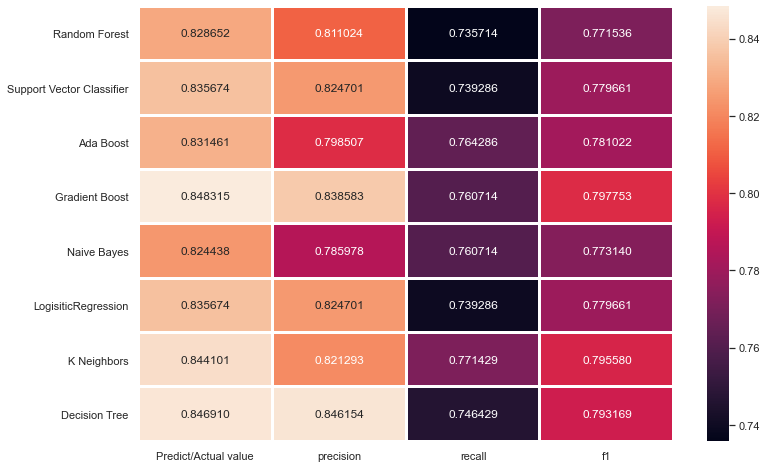

In [147]:
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(scores, linewidth=2,annot=True, fmt="f", ax=ax)
plt.show()

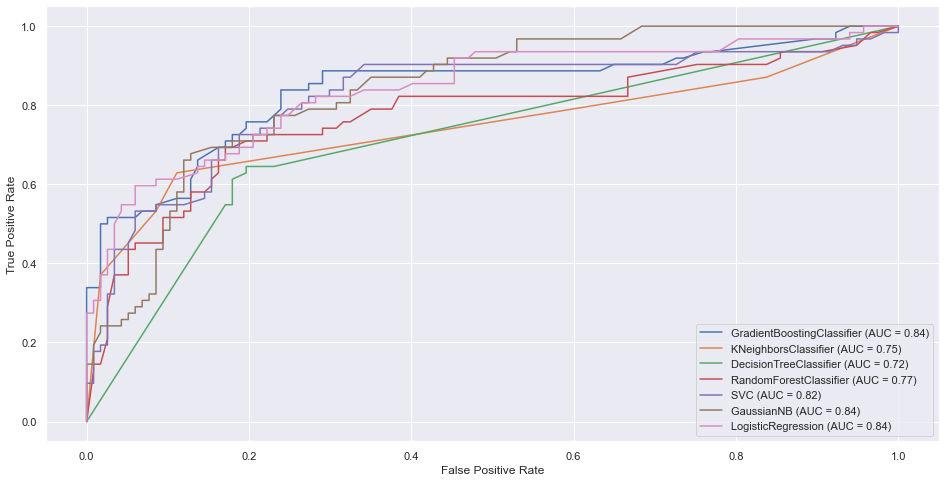

In [225]:
from sklearn.metrics import plot_roc_curve

RandomForestClassifier(random_state=42), 
SVC(random_state=42),
AdaBoostClassifier(random_state=42),
GaussianNB(), 
LogisticRegression(random_state=42),

clf_gb = GradientBoostingClassifier(random_state=42)
clf_kn = KNeighborsClassifier()
clf_dtree = DecisionTreeClassifier(random_state=42)
clf_rforest = RandomForestClassifier(random_state=42)
clf_svc = SVC(random_state=42)
clf_nb = GaussianNB()
clf_logreg = LogisticRegression(random_state=42)

clf_gb.fit(X_train, Y_train)
clf_kn.fit(X_train, Y_train)
clf_dtree.fit(X_train, Y_train)
clf_rforest.fit(X_train, Y_train)
clf_svc.fit(X_train, Y_train)
clf_nb.fit(X_train, Y_train)
clf_logreg.fit(X_train, Y_train)

strat_test_comb = attribute_transformer.add_features(strat_test, fun_list)
Y_test = strat_test_comb["Survived"].copy()
strat_test_comb = strat_test_comb.drop(columns=list(["Survived"]))
X_test = my_full_pipeline.fit_transform(strat_test_comb)



roc_curve = plot_roc_curve(clf_gb, X_test, Y_test)
plot_roc_curve(clf_kn, X_test, Y_test, ax=roc_curve.ax_)
plot_roc_curve(clf_dtree, X_test, Y_test, ax=roc_curve.ax_)
plot_roc_curve(clf_rforest, X_test, Y_test, ax=roc_curve.ax_)
plot_roc_curve(clf_svc, X_test, Y_test, ax=roc_curve.ax_)
plot_roc_curve(clf_nb, X_test, Y_test, ax=roc_curve.ax_)
plot_roc_curve(clf_logreg, X_test, Y_test, ax=roc_curve.ax_)

roc_curve.figure_.set_size_inches(16, 8, forward=True)

In [239]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[4,8,12]
    }

grid_search = GridSearchCV(estimator = clf_gb, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 5 folds for each of 72576 candidates, totalling 362880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 4200 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 8728 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 14568 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 21688 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 30120 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 39832 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 50856 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 63160 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 76776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 91672 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 107880 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 125368 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1441

{'criterion': 'mae',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.28181818181818186,
 'n_estimators': 8,
 'subsample': 1.0}

In [276]:
clf_gb_hyper = GradientBoostingClassifier(learning_rate = 0.1, min_samples_split = 0.3,
                                        min_samples_leaf = 0.1, max_depth=5,
                                        subsample=1, n_estimators = 8)
clf_gb_hyper.fit(X_train, Y_train)

classifiers = [clf_gb, clf_nb, clf_logreg, clf_gb_hyper]         

matrix_score =np.empty((4, 4))
for ix, clf in enumerate(classifiers):
    y_pred = clf.predict(X_test)
    n_correct = sum(y_pred == Y_test)
    matrix_score[ix,0] = n_correct/len(y_pred)
    matrix_score[ix,1] = precision_score(Y_test, y_pred)
    matrix_score[ix,2] = recall_score(Y_test, y_pred)
    matrix_score[ix,3] = f1_score(Y_test, y_pred)
    



classifiers = ["Gradient Boost", "Naives-Bayes", "Logistic Regression", "Gradient Boost Hyper"]
score_labels =["Predict/Actual value", "precision", "recall", "f1"]

scores = pd.DataFrame(data=matrix_score, index=classifiers, columns=score_labels)
scores

,Predict/Actual value,precision,recall,f1
Gradient Boost,0.787709,0.693548,0.693548,0.693548
Naives-Bayes,0.765363,0.647059,0.709677,0.676923
Logistic Regression,0.770950,0.672131,0.661290,0.666667
Gradient Boost Hyper,0.826816,0.942857,0.532258,0.680412


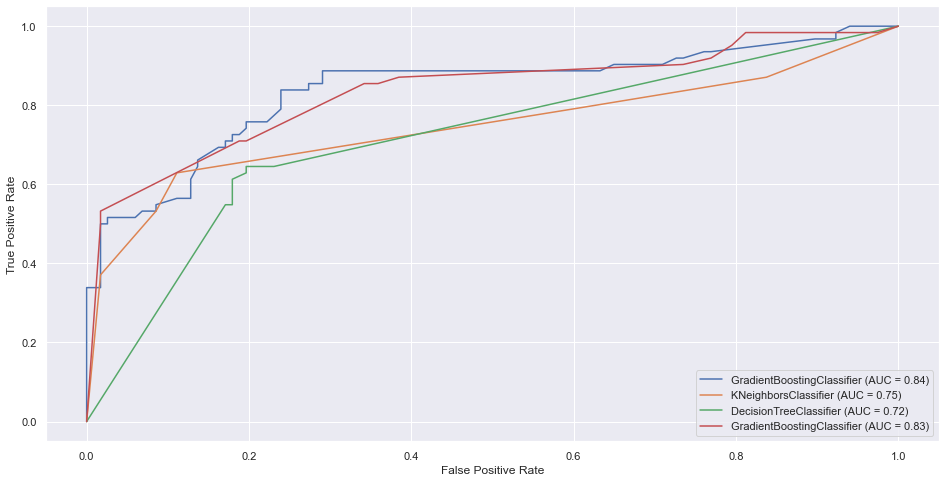

In [277]:
roc_curve = plot_roc_curve(clf_gb, X_test, Y_test)
plot_roc_curve(clf_kn, X_test, Y_test, ax=roc_curve.ax_)
plot_roc_curve(clf_dtree, X_test, Y_test, ax=roc_curve.ax_)
plot_roc_curve(clf_gb_hyper, X_test, Y_test, ax=roc_curve.ax_)

roc_curve.figure_.set_size_inches(16, 8, forward=True)